In [264]:
%load_ext autoreload
%autoreload 2

import numpy as np
seed = 123
rng = np.random.default_rng(seed)
import scipy.signal as sig

import IPython.display as ipd
import matplotlib.pyplot as plt

from hr.util import synth_sine, esprit, least_squares, \
    psd_noise, noise_filtre_coeffs, whiten, _PINK_FILTRE_COEFFS, \
    ester_inverse_error_func, ester
from util.util import to_db

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Simple noiseless 'harmonic' signal

In [254]:
sr = 44100
n_s = 100000
n_fft = 1024

r = 8 # number of sinusoids

deltas = rng.uniform(0.001, 0.01, r)
nus = rng.normal(0.1, 0.05, r)
amps = rng.uniform(0.1, 1, r)
phis = rng.uniform(0, 2*np.pi, r)

x_sine = synth_sine(n_s, deltas, nus, amps, phis) 

print(nus * sr)
print(deltas * sr)

[3711.90703018 3699.13199887 4624.25393767 1045.32345363 7038.72625954
 2930.24726624 6615.59407035 4710.5880781 ]
[314.92545452  65.46156236 131.5608335  117.27717167 113.91705214
 366.42030969 410.57562972 153.87237849]


/home/xabbu/anaconda3/envs/env_pam_hr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
/home/xabbu/anaconda3/envs/env_pam_hr/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


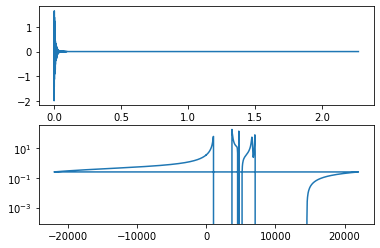

In [279]:
ts_plot = np.arange(n_s) / sr # times in seconds
nus_plot = np.fft.fftfreq(n_fft)

_, x_sine_psd = sig.welch(x_sine, fs=sr, nfft=n_fft)

plt.figure()
x_sine_ft = np.fft.fft(x_sine, n=n_fft)
plt.title("Time and frequency representation of the synthesised signal")
plt.subplot(2, 1, 1)
plt.plot(ts_plot, np.real(x_sine))
plt.subplot(2, 1, 2)
plt.semilogy(nus_plot * sr, x_sine_ft)

In [256]:
ipd.Audio(np.real(x_sine), rate=sr)

### Adding noise

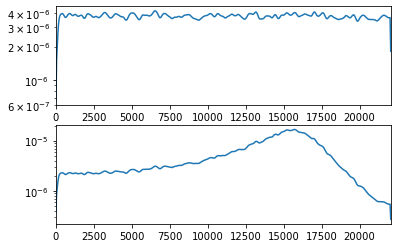

In [257]:
white_noise = rng.random(n_s)
pink_noise = sig.lfilter(_PINK_FILTRE_COEFFS["b"], _PINK_FILTRE_COEFFS["a"], white_noise)

fs_psd, white_noise_psd = sig.welch(white_noise, fs=sr, nfft=n_fft)
_, pink_noise_psd = sig.welch(pink_noise, fs=sr, nfft=n_fft)

plt.figure()
plt.title("White and pink noises")
plt.subplot(2, 1, 1)
plt.semilogy(fs_psd, white_noise_psd)
plt.xlim(np.array([0, 0.5])*sr)
plt.subplot(2, 1, 2)
plt.xlim(np.array([0, 0.5])*sr)
plt.semilogy(fs_psd, pink_noise_psd)
plt.show()

/home/xabbu/anaconda3/envs/env_pam_hr/lib/python3.9/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


width=4410.0 Hz


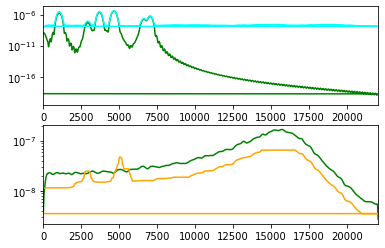

In [284]:
noise = 0.1*pink_noise
x = x_sine + noise

fs_x_psd, x_psd = sig.welch(x, fs=sr, nfft=n_fft)
fs_noise_psd, noise_psd = sig.welch(noise, fs=sr, nfft=n_fft)

nu_width = 0.1
print(f"width={nu_width*sr} Hz")
noise_psd_est = psd_noise(x_psd, nu_width=nu_width)

ar_order = 8

noise_filtre_coeffs_est = noise_filtre_coeffs(x, n_fft=n_fft, nu_width=nu_width, ar_order=ar_order)
# TODO: compare
# print(_PINK_FILTRE_COEFFS)
# print(noise_filtre_coeffs_est)
x_white = whiten(x, n_fft=n_fft, nu_width=nu_width, ar_order=ar_order)
_, x_white_psd = sig.welch(x_white, fs=sr, nfft=n_fft)
_, x_sine_psd = sig.welch(x_sine, fs=sr, nfft=n_fft)

plt.title("PSD of the noised synthesised signal")
plt.subplot(2, 1, 1)
plt.xlim(np.array([0, 0.5])*sr)
plt.semilogy(fs_x_psd, x_sine_psd, c='green')
plt.semilogy(fs_x_psd, x_white_psd, c='cyan')
plt.subplot(2, 1, 2)
plt.xlim(np.array([0, 0.5])*sr)
plt.semilogy(fs_noise_psd, noise_psd, c='green')
plt.semilogy(fs_x_psd, noise_psd_est, c='orange')
plt.show()

In [286]:
ipd.Audio(np.real(x), rate=sr)


### ESM model order estimation

#### Does not seem to be resistant to noise!

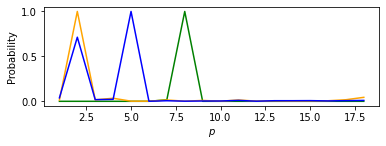

Order of the ESM model
Truth=8
Estimated: Noiseless=8, Noisy=2, Whitened=5


In [288]:
n = 20
p_max = n - 2 # for now
ps = np.arange(1,p_max+1)
j_sine = ester_inverse_error_func(x_sine, n, p_max)
j_noise = ester_inverse_error_func(x, n, p_max)
j_white = ester_inverse_error_func(x_white, n, p_max)

plt.figure()
plt.title('Estimated ESM order probabilities, noiseless and noisy signals')
plt.subplot(2, 1, 1)
plt.xlabel('$p$')
plt.ylabel('Probability')
plt.plot(ps, j_sine/np.max(j_sine), c='g')
plt.plot(ps, j_noise/np.max(j_noise), c='orange')
plt.plot(ps, j_white/np.max(j_white), c='b')
plt.show()

r_est_sine = ester(x_sine, n, p_max)
r_est_noise = ester(x, n, p_max)
r_est_white = ester(x_white, n, p_max)
print('Order of the ESM model')
print(f'Truth={r}')
print(f'Estimated: Noiseless={r_est_sine}, Noisy={r_est_noise}, Whitened={r_est_white}')


In [290]:
k = r_est_sine

deltas_est, nus_est = esprit(x_sine, n, k)
amps_est, phis_est = least_squares(x_sine, deltas, nus)

print(nus)
print(nus_est)
print(deltas)
print(deltas_est)


[0.08417023 0.08388054 0.10485837 0.02370348 0.15960831 0.06644552
 0.15001347 0.10681606]
[0.02370348 0.15960831 0.15001347 0.06644552 0.10485837 0.10681606
 0.08417021 0.08388085]
[0.00714117 0.00148439 0.00298324 0.00265935 0.00258315 0.00830885
 0.0093101  0.00348917]
[0.00265935 0.00258315 0.00931011 0.00830885 0.00298323 0.00348916
 0.00713946 0.00148312]
